In [1]:
from PIL import Image   
import numpy as np
import cv2
from PIL import ImageFilter

In [2]:
image_name = "mark.png"
image_path = "src_image/" + image_name
src_pic = cv2.imread(image_path)
nrow, ncol, _ = src_pic.shape

In [3]:
def min_max_normalize( array ):
    array_min, array_max = np.min( array ), np.max( array )
    return ( array - array_min ) / ( array_max - array_min )

# Color Adjustment

before


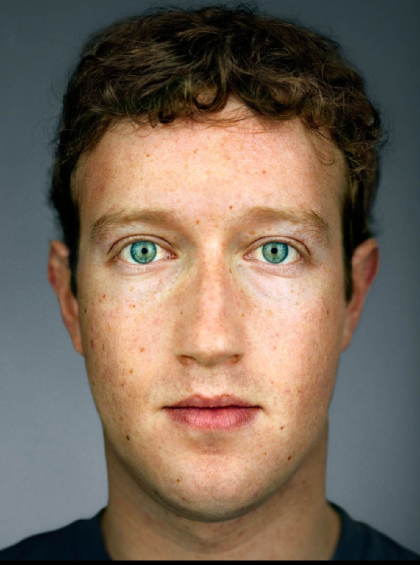

after


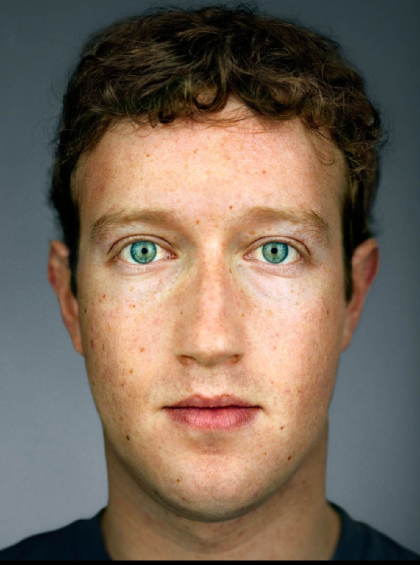

In [4]:
def readColorLib(libpath):
    ret = []
    with open(libpath) as f:
        for line in f:
            if(len(line)<=1):
                print(len(line))
                break
            line = line.split()
            line = np.array([float(x) for x in line ])
            ret.append(line)
    return np.array(ret)

def colorAdjust( src, colorlib ):
    ret_src = cv2.cvtColor(src.astype('float32')/255.0, cv2.COLOR_BGR2Lab)    
    means = []
    std_dev = []
    for i in range(3):
        means.append(np.mean(ret_src[:,:,i]))
        std_dev.append(np.std(ret_src[:,:,i]))
    
    mean_std = np.array(means+std_dev)
    diff_array = colorlib - mean_std
    print(diff_array.dtype, diff_array.shape)
    diff_array = np.linalg.norm( diff_array, axis=1)
    print( "select: ",np.argmin( diff_array ) )
    
    target_data = colorlib[ np.argmin( diff_array ) ]
    target_mean = target_data[ :3 ]
    target_std = target_data[ 3: ]
    for i in range(3):
        ret_src[:,:,i] -= means[i]
    
    for i in range(3):
        ret_src[:,:,i] *= target_std[i]/std_dev[i]
        ret_src[:,:,i] += target_mean[i]
    
    return np.uint8(cv2.cvtColor(ret_src, cv2.COLOR_Lab2BGR)*255.0)

def colorAdjust2( src, colorlib, which ):
    ret_src = cv2.cvtColor(src.astype('float32')/255.0, cv2.COLOR_BGR2Lab)
    
    means = []
    std_dev = []
    for i in range(3):
        means.append(np.mean(ret_src[:,:,i]))
        std_dev.append(np.std(ret_src[:,:,i]))
    
    mean_std = np.array(means+std_dev)
    target_data = colorlib[ which ]
    target_mean = target_data[ :3 ]
    target_std = target_data[ 3: ]
    print( mean_std )
    print( target_data )
    print( np.linalg.norm( mean_std-target_data ), which )
    for i in range(3):
        ret_src[:,:,i] -= means[i]
    
    for i in range(3):
        ret_src[:,:,i] *= target_std[i]/std_dev[i]
        ret_src[:,:,i] += target_mean[i]
    
    return np.uint8(cv2.cvtColor(ret_src, cv2.COLOR_Lab2BGR)*255.0)

# Do color adjustment
#####################
# mycolorlib = readColorLib("colorlib.txt")
# color_adjust_res = colorAdjust(src_pic, mycolorlib)

# Don't do color adjustment
#############################
color_adjust_res = np.array(src_pic)


print("before")
display(Image.fromarray(src_pic[:,:,::-1], "RGB"))
print("after")
display(Image.fromarray(color_adjust_res[:,:,::-1], "RGB"))
# for i in range(20):
#     display(Image.fromarray(colorAdjust2(src_pic, mycolorlib, i)[:,:,::-1], "RGB"))

# Abstraction
## Calculate Distance Map

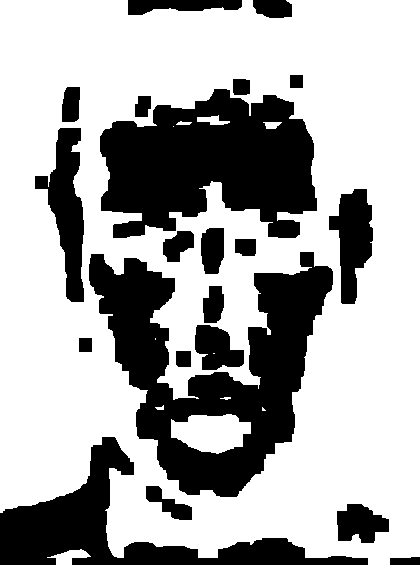

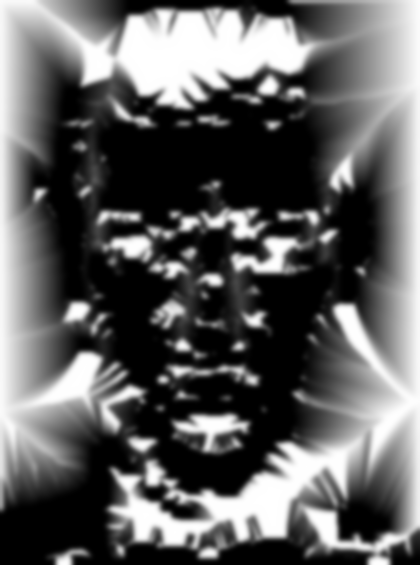

In [5]:
saliency_algo = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency_algo.computeSaliency(color_adjust_res)
if(not success):
    raise
    
saliencyMap = (saliencyMap * 255).astype("uint8")
saliencyMap = cv2.threshold(saliencyMap, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

kernel = np.ones((7,7), np.uint8)

saliencyMap = cv2.erode(saliencyMap, kernel, iterations = 1)
saliencyMap = cv2.dilate(saliencyMap, kernel, iterations = 2)

saliencyMap = 255 - saliencyMap

distanceMap, labels = cv2.distanceTransformWithLabels(saliencyMap, cv2.DIST_L2, 5, labelType=cv2.DIST_LABEL_PIXEL)

# normalize
nearest_0_point_map = np.zeros( (np.max(labels)+1, 2) )
# print(nearest_0_point_map.shape)
for i in range( nrow ):
    for j in range( ncol ):
        if( distanceMap[i][j] == 0 ):
            nearest_0_point_map[ labels[i][j] ][0] = i
            nearest_0_point_map[ labels[i][j] ][1] = j

normalize_map = np.array(distanceMap)
for i in range( nrow ):
    for j in range( ncol):
        if( distanceMap[i][j] == 0 ):
            continue
        nearest_point = nearest_0_point_map[ labels[i][j] ]
        distance = np.array([i, j]) - nearest_point
        t = np.inf
        if( distance[0] > 0.0 ):
            # bottom
            t = (nrow - nearest_point[0] - 1) / distance[0]
        elif(distance[0] < -0.0):
            # top
            t = -1*(nearest_point[0]) / distance[0]
        
        if( distance[1] > 0.0 ):
            # right
            t = min(t, (ncol - nearest_point[1] - 1) / distance[1])
        elif(distance[1] < -0.0):
            # left
            t = min(t, -1*(nearest_point[1]) / distance[1])
        
        borderPoint = np.int32(nearest_point + t * distance)
        border_d = distanceMap[borderPoint[0]][borderPoint[1]]
        if(border_d == 0):
#             print( nearest_point )
#             print(i,j)
            normalize_map[i][j] = 1
        else:
            normalize_map[i][j] = min(distanceMap[i][j]/border_d, 1)

for i in range(6):
    normalize_map = cv2.GaussianBlur(normalize_map,(5,5),0)
    
display(Image.fromarray(np.uint8(saliencyMap), 'L'))
display(Image.fromarray(np.uint8(normalize_map*255), 'L'))


## Segement

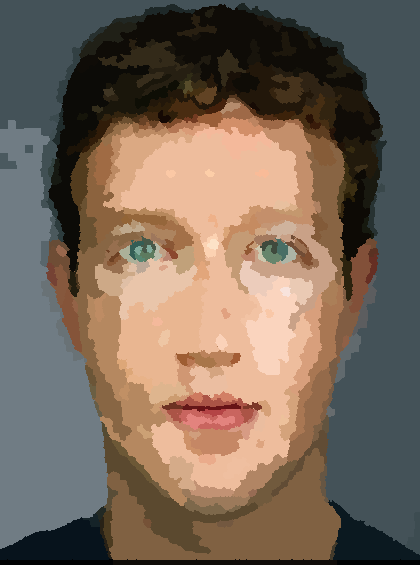

In [6]:
segment_pic = np.zeros(src_pic.shape, dtype="uint8")
segment_pic = cv2.hfs.HfsSegment_create(nrow, ncol, 0.08, 50, 0.08, 50, 0.6, 8, 5).performSegmentGpu( color_adjust_res, True)

display(Image.fromarray(segment_pic[:,:,::-1], "RGB"))



##########################################################################
# cv2.pyrMeanShiftFiltering( cv2.cvtColor(color_adjust_res, cv2.COLOR_BGR2Lab), 16,11, segment_pic )

# segment_pic = cv2.cvtColor(segment_pic, cv2.COLOR_Lab2BGR)
# for i in range(2):
#     segment_pic = cv2.GaussianBlur(segment_pic,(5,5),0)

# display(Image.fromarray(segment_pic[:,:,::-1], "RGB"))

# flood_fill_mask = np.zeros( (nrow+2, ncol+2), dtype="uint8" )
# flood_lo = (2,2,2)
# flood_hi = (2,2,2)
# small_area_mask = np.ones( (nrow, ncol), dtype="uint8" )
# small_area_indlist = []
# area_sum = 0
# for i in range(nrow):
#     if(i%100==0):
#         print(i, nrow)

#     for j in range(ncol):
#         if( flood_fill_mask[i+1][j+1] == 0 ):
#             old_mask = np.array(flood_fill_mask)
#             fill_color = (np.random.randint(0,256), np.random.randint(0,256), np.random.randint(0,256))
#             cv2.floodFill( segment_pic, flood_fill_mask, (j, i), fill_color, flood_lo, flood_hi )
#             mask_diff = (  flood_fill_mask[1:-1,1:-1] - old_mask[1:-1,1:-1] )
#             area_size = np.sum( mask_diff.astype("int32") )
#             # print(area_size)
#             area_sum += area_size
#             if( area_size <= 50 ):
#                 small_area_indlist.append( np.where( mask_diff==1 ) )
#                 small_area_mask -= mask_diff

                
# display(Image.fromarray(segment_pic[:,:,::-1], "RGB"))
# display(Image.fromarray(small_area_mask*255, "L"))

# eliminate small region

# distanceMap, labels = cv2.distanceTransformWithLabels(1-small_area_mask, cv2.DIST_L2, 5, labelType=cv2.DIST_LABEL_PIXEL)
# nearest_0_point_map = np.zeros( (np.max(labels)+1, 2) )
# for i in range( nrow ):
#     for j in range( ncol ):
#         if( distanceMap[i][j] == 0 ):
#             nearest_0_point_map[ labels[i][j] ][0] = i
#             nearest_0_point_map[ labels[i][j] ][1] = j

# flood_fill_mask = np.zeros( (src_pic.shape[0]+2, src_pic.shape[1]+2), dtype="uint8" )
# flood_fill_mask[1:-1, 1:-1] += small_area_mask

# for small_area_ind in small_area_indlist:
#     color_accumulate_set = np.zeros( (256,256,256), dtype="int32" )
#     for j in range( len(small_area_ind[0]) ):
#         row, col = small_area_ind[0][j], small_area_ind[1][j]
#         nearest_0_point = np.int32(nearest_0_point_map[ labels[row][col] ])
#         fill_color = np.int32(segment_pic[nearest_0_point[0], nearest_0_point[1]])
#         color_accumulate_set[ fill_color ] += 1
    
#     fill_color = (int(fill_color[0]), int(fill_color[1]), int(fill_color[2]))
#     cv2.floodFill( segment_pic, flood_fill_mask, (col, row), fill_color, (0,0,0), (0,0,0) )


# display(Image.fromarray(segment_pic[:,:,::-1], "RGB"))



## Do Abstraction

0 565
100 565
200 565
300 565
400 565
500 565


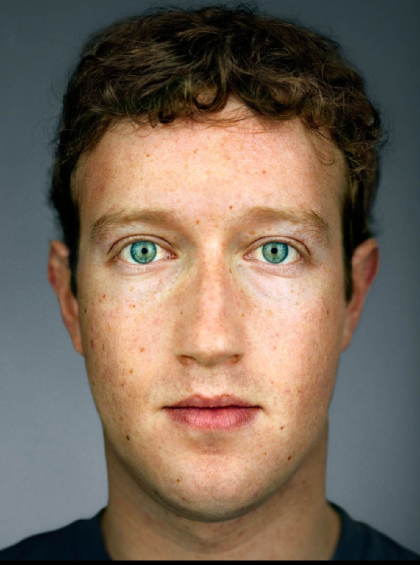

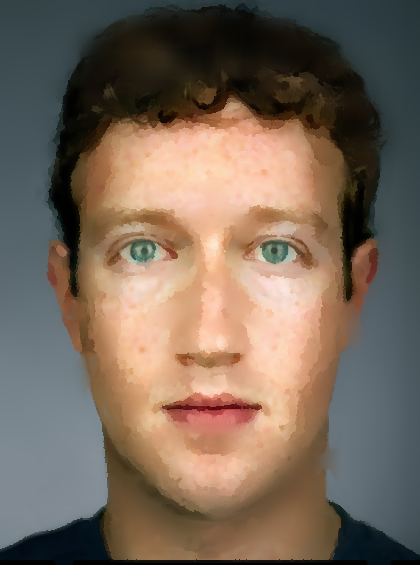

In [7]:
segment_pic, normalize_map, color_adjust_res, saliencyMap
abstraction_res = np.zeros(color_adjust_res.shape).astype("uint8")
int_color_adjust_res = color_adjust_res.astype("int32")
normalize_map_threshold = 0.03
for i in range( nrow ):
    if(i%100==0):
        print(i, nrow)
    for j in range(ncol):
        k = 2
        is_saliency = False
        d = normalize_map[i][j]
        if( normalize_map[i][j] <= normalize_map_threshold ):
            is_saliency = True
        else:
            k = np.clip( 5*2*(d+0.3), 4, 9 )*1.5
            
        r_start, r_end = int(max( 0, i-k )), int(min( nrow, i+k+1 ))
        c_start, c_end = int(max( 0, j-k )), int(min( ncol, j+k+1 ))
        color_diff = int_color_adjust_res[ r_start:r_end, c_start:c_end ] - int_color_adjust_res[i][j]
        color_diff = np.linalg.norm( color_diff, axis=2 )
#         dist_diff = np.abs(normalize_map[ r_start:r_end, c_start:c_end ] - normalize_map[i][j])
        seg_local_data = segment_pic[ r_start:r_end, c_start:c_end ]
        color_adjust_local = color_adjust_res[ r_start:r_end, c_start:c_end ]
        if( is_saliency ):
            valid_pos = np.prod((seg_local_data == segment_pic[i][j]), axis=2)
        else:
            valid_pos = np.prod((seg_local_data == segment_pic[i][j]), axis=2)
            valid_pos = np.logical_or( color_diff < 100*d, valid_pos )
#             k = np.sum(np.logical_and(np.logical_xor( dist_diff < 0.3*d, np.prod((seg_local_data == segment_pic[i][j]), axis=2) ), dist_diff < 0.3*d))
#             if(k>0):
#                 print(k)
        
        valid_pos = np.repeat( valid_pos, 3, axis=1 ).reshape( color_adjust_local.shape )
        res_data = (valid_pos * color_adjust_local).astype("float64")
        res_data = np.sum( res_data, axis=(0,1) ) / (np.sum( valid_pos )/3)
        abstraction_res[i][j] = res_data.astype("uint8")

    
        
display(Image.fromarray(color_adjust_res[:,:,::-1], "RGB"))
display(Image.fromarray(abstraction_res[:,:,::-1], "RGB"))


# Edge detection for Hand Tremor and Wet-In-Wet

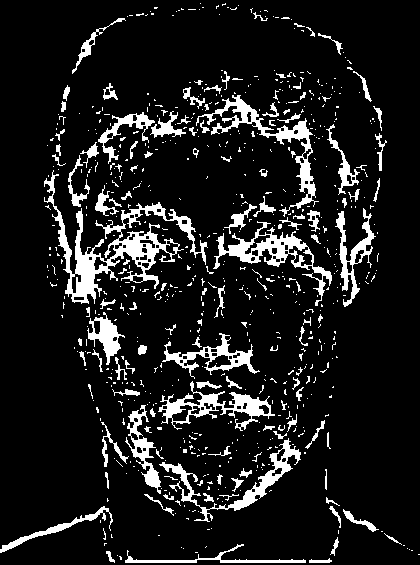

17934
18455
5386


In [8]:
abstraction_res
ddepth = cv2.CV_16S
abstraction_gray = cv2.cvtColor(abstraction_res, cv2.COLOR_BGR2GRAY)
grad_x = cv2.Scharr(abstraction_gray, ddepth, 1, 0)
grad_y = cv2.Scharr(abstraction_gray, ddepth, 0, 1)
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
abstraction_grad_map = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
edge_map = cv2.erode(abstraction_grad_map, np.ones((3,3), dtype="uint8"), iterations=1)

edge_map = cv2.threshold(edge_map, 240, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

display(Image.fromarray(edge_map, "L"))

def cal_angle(a, b):
    return min(abs(a - b), 180 - abs(a - b));

abstraction_res_hsv = cv2.cvtColor(abstraction_res.astype("float32"), cv2.COLOR_BGR2HSV)
for i in range(nrow):
    for j in range(ncol):
        if( edge_map[i][j] != 255 ):
            continue
        
        dc, dr = float(grad_x[i, j]), float(grad_y[i, j])
        now_grad_mag = np.sqrt( dc*dc+dr*dr )
        # print( dc, dr )
        bright_r, bright_c = round(i + 3*dr/now_grad_mag), round(j + 3*dc/now_grad_mag)
        dark_r, dark_c = round(i - 3*dr/now_grad_mag), round(j - 3*dc/now_grad_mag)
        bright_r = np.clip(bright_r, 0, nrow-1); bright_c = np.clip(bright_c, 0, ncol-1)
        dark_r = np.clip(dark_r, 0, nrow-1); dark_c = np.clip(dark_c, 0, ncol-1)
        bright_h = abstraction_res_hsv[bright_r, bright_c][0]
        dark_h = abstraction_res_hsv[dark_r, dark_c][0]
        
        if( (normalize_map[i][j] <= normalize_map_threshold and cal_angle( bright_h, dark_h ) < 5 ) 
         or (normalize_map[i][j] >  normalize_map_threshold and cal_angle( bright_h, dark_h ) < 20 ) ):
            edge_map[i][j] = 1 # wet-in-wet
        
        elif( cal_angle( bright_h, dark_h ) < 45 ):
            u_start, u_end = max(0, i-3), min(nrow, i+4)
            v_start, v_end = max(0, j-3), min(ncol, j+4)
            for u in range( u_start, u_end ):
                for v in range( v_start, v_end ):
                    if( edge_map[u][v] != 1 and edge_map[u][v] != 3 ):
                        edge_map[u][v] = 2
        else:
            u_start, u_end = max(0, i-3), min(nrow, i+4)
            v_start, v_end = max(0, j-3), min(ncol, j+4)
            for u in range( u_start, u_end ):
                for v in range( v_start, v_end ):
                    if( edge_map[u][v] != 1 and edge_map[u][v] != 2 ):
                        edge_map[u][v] = 3
print(np.sum(edge_map==1))
print(np.sum(edge_map==2))
print(np.sum(edge_map==3))

# Hand Tremor Effect

In [9]:
def perlin(x,y):
    
    def lerp(a,b,x):
        return a + x * (b-a)

    def fade(t):
#         "6t^5 - 15t^4 + 10t^3"
        return 6 * t**5 - 15 * t**4 + 10 * t**3

    def gradient(h,x,y):
        vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
        g = vectors[h%4]
        return g[:,:,0] * x + g[:,:,1] * y

    p = np.arange(512,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()

    xi = x.astype(int) % 512
    yi = y.astype(int) % 512

    xf = x - xi
    yf = y - yi

    u = fade(xf)
    v = fade(yf)

    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)

    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) 
    return lerp(x1,x2,v) 

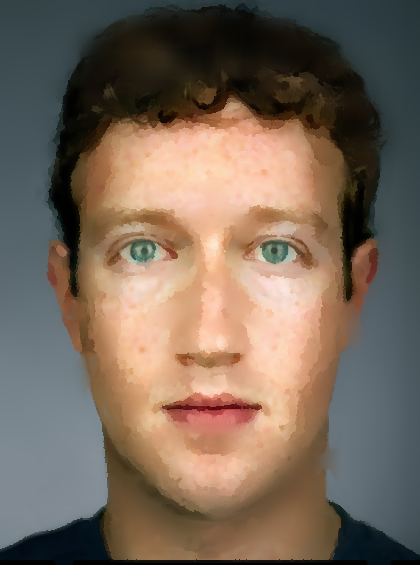

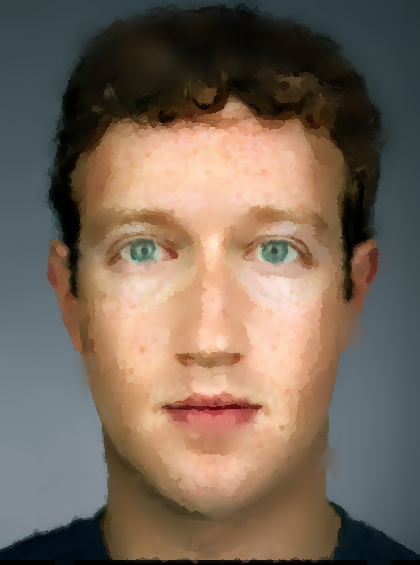

In [10]:
abstraction_res, edge_map
hand_tremor_res = np.array( abstraction_res )

lin1 = np.arange(0, nrow*0.1, 0.1)
lin2 = np.arange(0, ncol*0.1, 0.1)
x,y = np.meshgrid(lin2,lin1)

noise = []
for i in range(4):
    tmp = perlin(x,y)
    tmp = min_max_normalize(tmp)
    tmp = (tmp-0.5)*10
    noise.append( tmp )

for i in range(1, nrow-1, 1):
    for j in range(1, ncol-1, 1):
        if( edge_map[i][j] == 2 ):
            tremor_row, tremor_col = round( i+noise[0][i][j] ), round( j+noise[1][i][j] )
            tremor_row = np.clip( tremor_row, 0, nrow-1 )
            tremor_col = np.clip( tremor_col, 0, ncol-1 )
            color1 = np.float32(abstraction_res[tremor_row][tremor_col])
            color2 = np.float32(abstraction_res[i][j])
            hand_tremor_res[i][j] = np.uint8( (color1+2*color2)/3.0 )
        elif( edge_map[i][j] == 3 ):
            tremor_row, tremor_col = round( i+noise[0][i][j] ), round( j+noise[1][i][j] )
            tremor_row = np.clip( tremor_row, 0, nrow-1 )
            tremor_col = np.clip( tremor_col, 0, ncol-1 )
            color1 = np.float32(abstraction_res[tremor_row][tremor_col])
            
            tremor_row, tremor_col = round( i+noise[2][i][j] ), round( j+noise[3][i][j] )
            tremor_row = np.clip( tremor_row, 0, nrow-1 )
            tremor_col = np.clip( tremor_col, 0, ncol-1 )
            color2 = np.float32(abstraction_res[tremor_row][tremor_col])
            color3 = np.float32(abstraction_res[i][j])
            hand_tremor_res[i][j] = np.uint8((color1+color2+2*color3)/4.0)

display(Image.fromarray(abstraction_res[:,:,::-1], "RGB"))
display(Image.fromarray(hand_tremor_res[:,:,::-1], "RGB"))


# Wet In Wet

kernel_sum 12.25


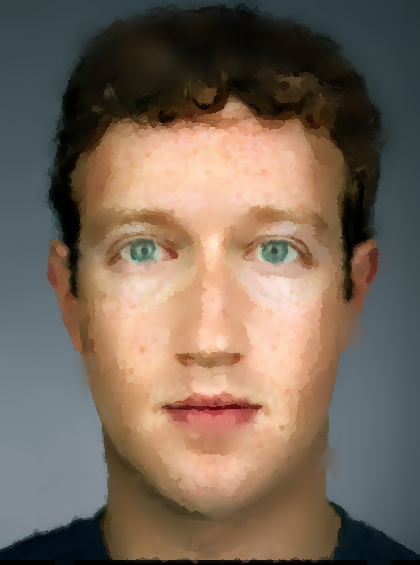

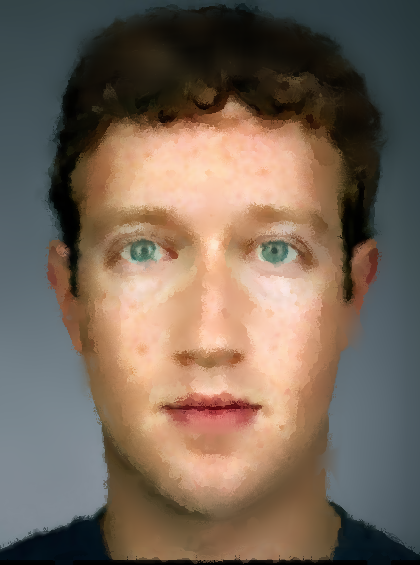

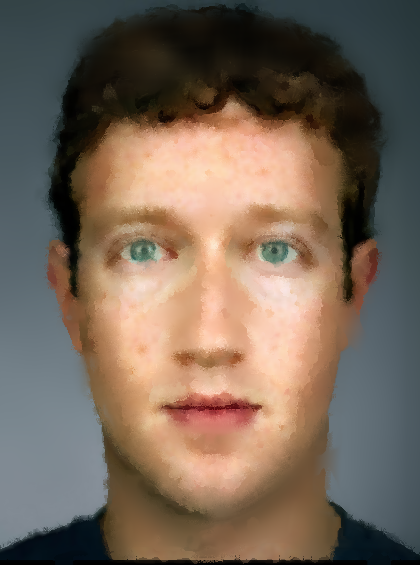

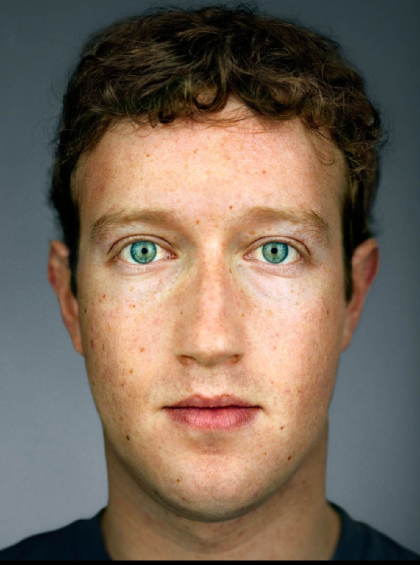

In [11]:

# scatter the noise
wetinwet_noise = np.array( hand_tremor_res )
for i in range(1, nrow-1, 1):
    for j in range(1, ncol-1, 1):
        if( edge_map[i][j] != 1 ):
            continue
        dc, dr = float(grad_x[i, j]), float(grad_y[i, j])
        now_grad_mag = np.sqrt( dc*dc+dr*dr )
        for noisenum in range(3):
            tr = np.random.uniform(1, 4)
            tc = np.random.uniform(1, 4)
            noise_row, noise_col = round(i + tr*dr/now_grad_mag), round(j + tc*dc/now_grad_mag)
            noise_row, noise_col = np.clip( noise_row, 0, nrow-1 ), np.clip( noise_col, 0, ncol-1 )
            # print( noise_row-i, noise_col-j )
            abcde = np.int32(hand_tremor_res[i][j]) + np.int32(wetinwet_noise[noise_row][noise_col])
            abcde = abcde / 2
            wetinwet_noise[noise_row][noise_col] = (abcde).astype("uint8")

kernel_len = 15
kernel = np.zeros( (kernel_len, kernel_len) )
for i in range( len(kernel[0]) ):
    kernel[kernel_len//2][i] = min( i, kernel_len-1-i ) / ( kernel_len//2 )
    kernel[kernel_len//2+1][i] = min( i, kernel_len-1-i )/ (2*(kernel_len-1))
    kernel[kernel_len//2-1][i] = min( i, kernel_len-1-i )/ (2*(kernel_len-1))
    kernel[kernel_len//2+2][i] = min( i, kernel_len-1-i )/ (4*(kernel_len-1))
    kernel[kernel_len//2-2][i] = min( i, kernel_len-1-i )/ (4*(kernel_len-1))
#     kernel[kernel_len//2+3][i] = min( i, kernel_len-1-i )/ (8*(kernel_len-1))
#     kernel[kernel_len//2-3][i] = min( i, kernel_len-1-i )/ (8*(kernel_len-1))


kernel_sum = np.sum(kernel)
print("kernel_sum", kernel_sum)
display(Image.fromarray(hand_tremor_res[:,:,::-1], "RGB"))
display(Image.fromarray(wetinwet_noise[:,:,::-1], "RGB"))
wetinwet_res = np.array( wetinwet_noise )
wetinwet_noise = wetinwet_noise.astype("float64")

finish_map = np.zeros((nrow, ncol)).astype("uint8")
for i in range(1, nrow-1):
    for j in range(1, ncol-1):
        if( edge_map[i][j] != 1 ):
            continue
        # print(i,j)
        angle_noise = np.random.uniform( -1*np.pi/3, np.pi/3 )
        tmpdc, tmpdr = float(grad_x[i, j]), float(grad_y[i, j])
        dr = np.sin(angle_noise) * tmpdc + np.cos(angle_noise) * tmpdr
        dc = np.cos(angle_noise) * tmpdc - np.sin(angle_noise) * tmpdr
        now_grad_mag = np.sqrt( dc*dc+dr*dr )
        if( grad_x[i,j ] != 0  ):
            grad_angle = np.arctan( grad_y[i,j ] / grad_x[i,j ] )/(2*np.pi)*360
        elif( grad_y[i,j] > 0 ):
            grad_angle = 90
        else:
            grad_angle = 270

        rot_mat = cv2.getRotationMatrix2D((kernel_len//2, kernel_len//2), -grad_angle, 1.0)
        new_kernel = cv2.warpAffine(kernel, rot_mat, kernel.shape)
        new_kernel = np.repeat( new_kernel, 3, axis=1 ).reshape((kernel_len, kernel_len, 3))
        tmp_g = -1*np.random.randint(1,3)
        k_row, k_col = round(i + tmp_g*dr/now_grad_mag)  , round(j + tmp_g*dc/now_grad_mag)
        for k in range( -1*tmp_g + 4 ):
            k_row, k_col = round(k_row + dr/now_grad_mag), round(k_col + dc/now_grad_mag)
            if( k_row < 0 or k_row >= nrow or k_col < 0 or k_col >= ncol  ):
                break
            if( edge_map[k_row][k_col] == 1 ):
                continue
            if( finish_map[k_row][k_col] == 1 ):
                continue
                
            finish_map[k_row][k_col] = 1
            kr_start, kr_end = max( k_row-kernel_len//2, 0 ), min( k_row+kernel_len//2+1, nrow)
            kc_start, kc_end = max( k_col-kernel_len//2, 0 ), min( k_col+kernel_len//2+1, ncol)

            # crop the kernel
            if( kc_start!=k_col-kernel_len//2 or kc_end!=k_col+kernel_len//2+1 or
                kr_start!=k_row-kernel_len//2 or kr_end!=k_row+kernel_len//2+1):
                break
            else:
                tmp_res = np.sum(new_kernel * wetinwet_noise[kr_start:kr_end, kc_start:kc_end], axis=(0,1))
                # print(tmp_res / kernel_sum)
                wetinwet_res[k_row, k_col] = np.uint8( np.clip(tmp_res / kernel_sum, 0, 255) )
                        
display(Image.fromarray(wetinwet_res[:,:,::-1], "RGB"))  
display(Image.fromarray(src_pic[:,:,::-1], "RGB"))          


# Edge Darkening

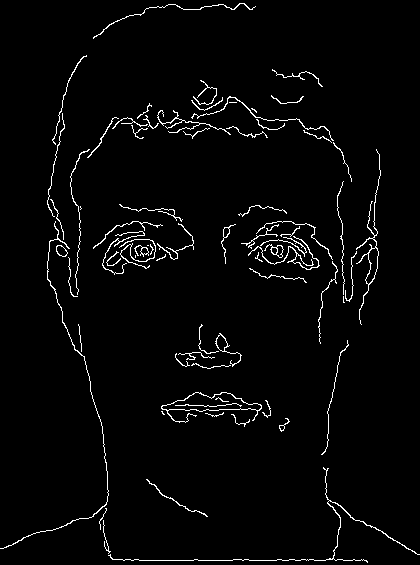

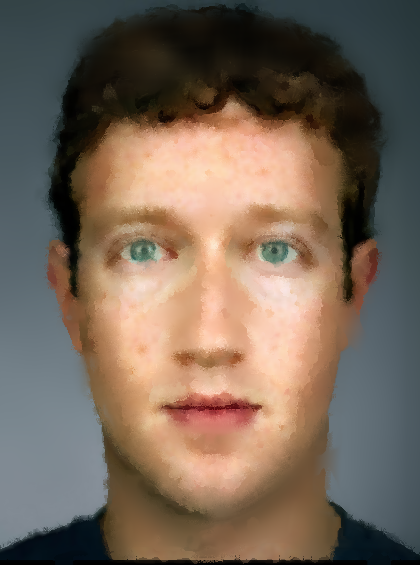

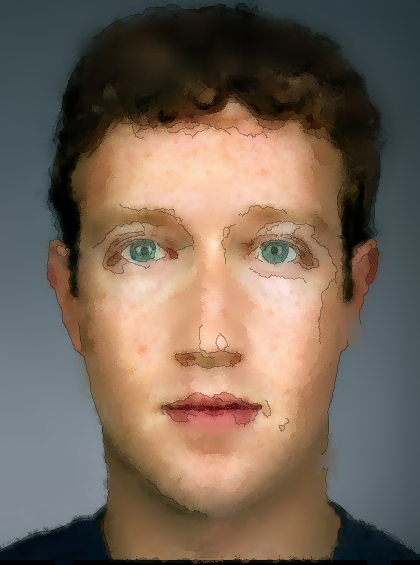

In [12]:
blur_abstraction = cv2.GaussianBlur(abstraction_res, (5, 5), 0)
edge_map = cv2.Canny(blur_abstraction, 50, 150)


display(Image.fromarray(np.uint8(edge_map), "L"))  

darkening_map = np.ones(edge_map.shape) - np.float32(edge_map)/255*0.3
darkening_map = np.repeat( darkening_map, 3, axis=1 ).reshape((nrow, ncol, 3))
edge_dark_res = np.uint8(darkening_map * np.float32(wetinwet_res))
display(Image.fromarray(wetinwet_res[:,:,::-1], "RGB"))  
display(Image.fromarray(edge_dark_res[:,:,::-1], "RGB"))  


# Granulation

In [13]:
# Don't do the Granulation
##############################################
granulation_res = edge_dark_res

# Do the Granulation
##############################################
# granulation_noise = np.zeros( (nrow, ncol) )
# scale = 0.4
# for i in range(2):
#     lin1 = np.linspace( 0, nrow*scale, nrow )
#     lin2 = np.linspace( 0, ncol*scale, ncol )
#     x,y = np.meshgrid(lin2,lin1)
#     tmp = perlin( x, y ) * 8 * scale
#     granulation_noise += tmp
#     scale /= 2

# granulation_noise = min_max_normalize( granulation_noise )
# granulation_noise *= 0.25
# granulation_noise += 0.95

# granulation_noise = np.repeat( granulation_noise, 3, axis=1 ).reshape( src_pic.shape )
# granulation_res = np.clip(np.float32(edge_dark_res) * granulation_noise, 0, 255)
# granulation_res = np.uint8( granulation_res )
# display(Image.fromarray(granulation_res[:,:,::-1], "RGB"))  


# Turbulence Flow

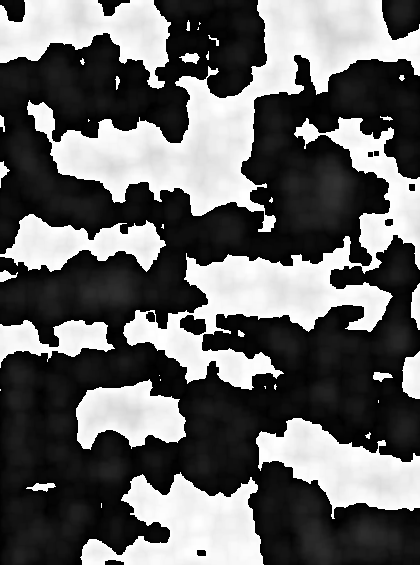

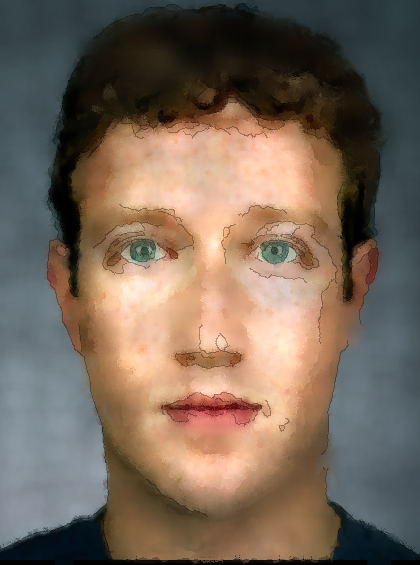

In [14]:
turbulence_noise = np.zeros( (nrow, ncol) )

scale = 0.25
for i in range(6):
    lin1 = np.linspace( 0, nrow*scale*(i%2+1), nrow )
    lin2 = np.linspace( 0, ncol*scale*((i+1)%2+1), ncol )
    x,y = np.meshgrid(lin2,lin1)
    tmp = perlin( x, y ) * 8 / scale
    turbulence_noise += tmp
    scale /= 2

turbulence_noise = min_max_normalize( turbulence_noise )
turbulence_noise = cv2.dilate(turbulence_noise, np.ones((5,5), dtype="uint8"), iterations=1)
turbulence_noise *= 0.4
turbulence_noise += 0.8

display(Image.fromarray( np.uint8(turbulence_noise*255) , "L"))  


turbulence_noise = np.repeat( turbulence_noise, 3, axis=1 ).reshape( src_pic.shape )
turbulence_res = np.clip(np.float32(granulation_res) * turbulence_noise, 0, 255)
turbulence_res = np.uint8( turbulence_res )
display(Image.fromarray(turbulence_res[:,:,::-1], "RGB"))  


# Watercolor Paper Texture

T
(565, 420, 3)
(1500, 1000)
632.0 422.0


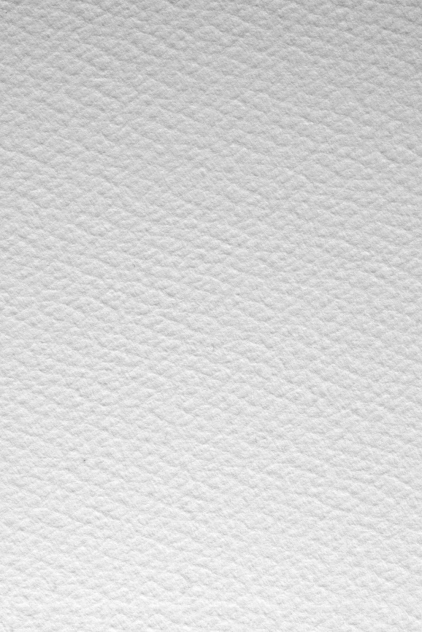

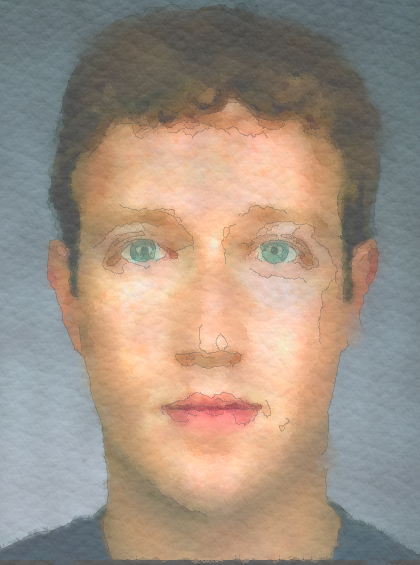

True

In [15]:

final_res = turbulence_res

texture_path = "texture3.jpg"
texture_pic = cv2.imread(texture_path, cv2.IMREAD_GRAYSCALE)
if( (texture_pic.shape[0] < texture_pic.shape[1]) != (nrow < ncol) ):
    print("T")
    texture_pic = np.transpose(texture_pic)
    
print( turbulence_res.shape )
print( texture_pic.shape )

texure_resize_scale = max( nrow/texture_pic.shape[0], ncol/texture_pic.shape[1] )
texture_r, texture_c = np.ceil(texture_pic.shape[0]*texure_resize_scale)+2,  np.ceil(texture_pic.shape[1]*texure_resize_scale)+2
texture_pic = cv2.resize(texture_pic, (int(texture_c), int(texture_r)), interpolation=cv2.INTER_AREA)    
print( texture_r, texture_c )
    
texture_means = np.mean( texture_pic )
texture_r, texture_c = texture_pic.shape

display(Image.fromarray(texture_pic, "L"))  
texture_filter = np.zeros( (nrow, ncol) )
for i in range( 0, nrow, texture_r ):
    for j in range( 0, ncol, texture_c ):
        now_r, now_c = min( nrow-i, texture_r ) , min( ncol-j, texture_c )
        tmp = np.float32(texture_pic[:now_r, :now_c])
        texture_filter[i:i+now_r, j:j+now_c] += tmp

turbulence_res_Ycbcr = cv2.cvtColor(turbulence_res, cv2.COLOR_BGR2YCR_CB)
src_ratio = 1.5
turbulence_res_Ycbcr[:,:,0] = np.uint8((texture_filter.astype("float32") + 
                                src_ratio*turbulence_res_Ycbcr[:,:,0].astype("float32"))/(src_ratio+1))

# final_res = np.clip(turbulence_res.astype("float32") * texture_filter, 0, 255)
final_res = cv2.cvtColor(turbulence_res_Ycbcr, cv2.COLOR_YCR_CB2BGR)

display(Image.fromarray(final_res[:,:,::-1], "RGB"))  
res_path =  image_name.split('.')[0] + f"_res.jpg"
cv2.imwrite(res_path, final_res)